In [ ]:
import os
import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError, Huber
from statsmodels.tsa.arima.model import ARIMA
import joblib

# **Data pre-processing**

In [ ]:
# Read the CSV file
gbp_exchange_rates_df = pd.read_csv("/content/GBP_ExchangeRates_Daily.csv", parse_dates=["Date"], dayfirst=False)

# Convert both date columns to a consistent format (YYYY-MM-DD)
gbp_exchange_rates_df["Date"] = pd.to_datetime(gbp_exchange_rates_df["Date"]).dt.strftime("%Y-%m-%d")

currency_df = gbp_exchange_rates_df.copy()
currency_df = currency_df.dropna()
print(currency_df.shape)
currency_df.tail()

(2606, 5)


,Date,GBP_EUR,GBP_USD,GBP_HKD,GBP_JPY
2604,2024-12-25,1.2067,1.2561,9.7552,197.050
2605,2024-12-26,1.2019,1.2525,9.7302,197.904
2606,2024-12-27,1.2064,1.2578,9.7649,198.526
2607,2024-12-30,1.2061,1.2550,9.7483,196.846
2608,2024-12-31,1.2085,1.2516,9.7212,196.764


In [ ]:
plot_df = currency_df.copy()

# Ensure the 'Date' column is in datetime format
plot_df['Date'] = pd.to_datetime(plot_df['Date'])

# plot_df.set_index('Date', inplace=True)

# Sort the data by date
plot_df = plot_df.sort_values(by='Date')

plot_df.head()

,Date,GBP_EUR,GBP_USD,GBP_HKD,GBP_JPY
0,2015-01-01,1.2875,1.5586,12.0859,186.630
1,2015-01-02,1.2772,1.5328,11.8890,184.698
2,2015-01-05,1.2779,1.5250,11.8271,182.437
3,2015-01-06,1.2743,1.5151,11.7488,179.374
4,2015-01-07,1.2763,1.5110,11.7181,180.201


# **Visualization**

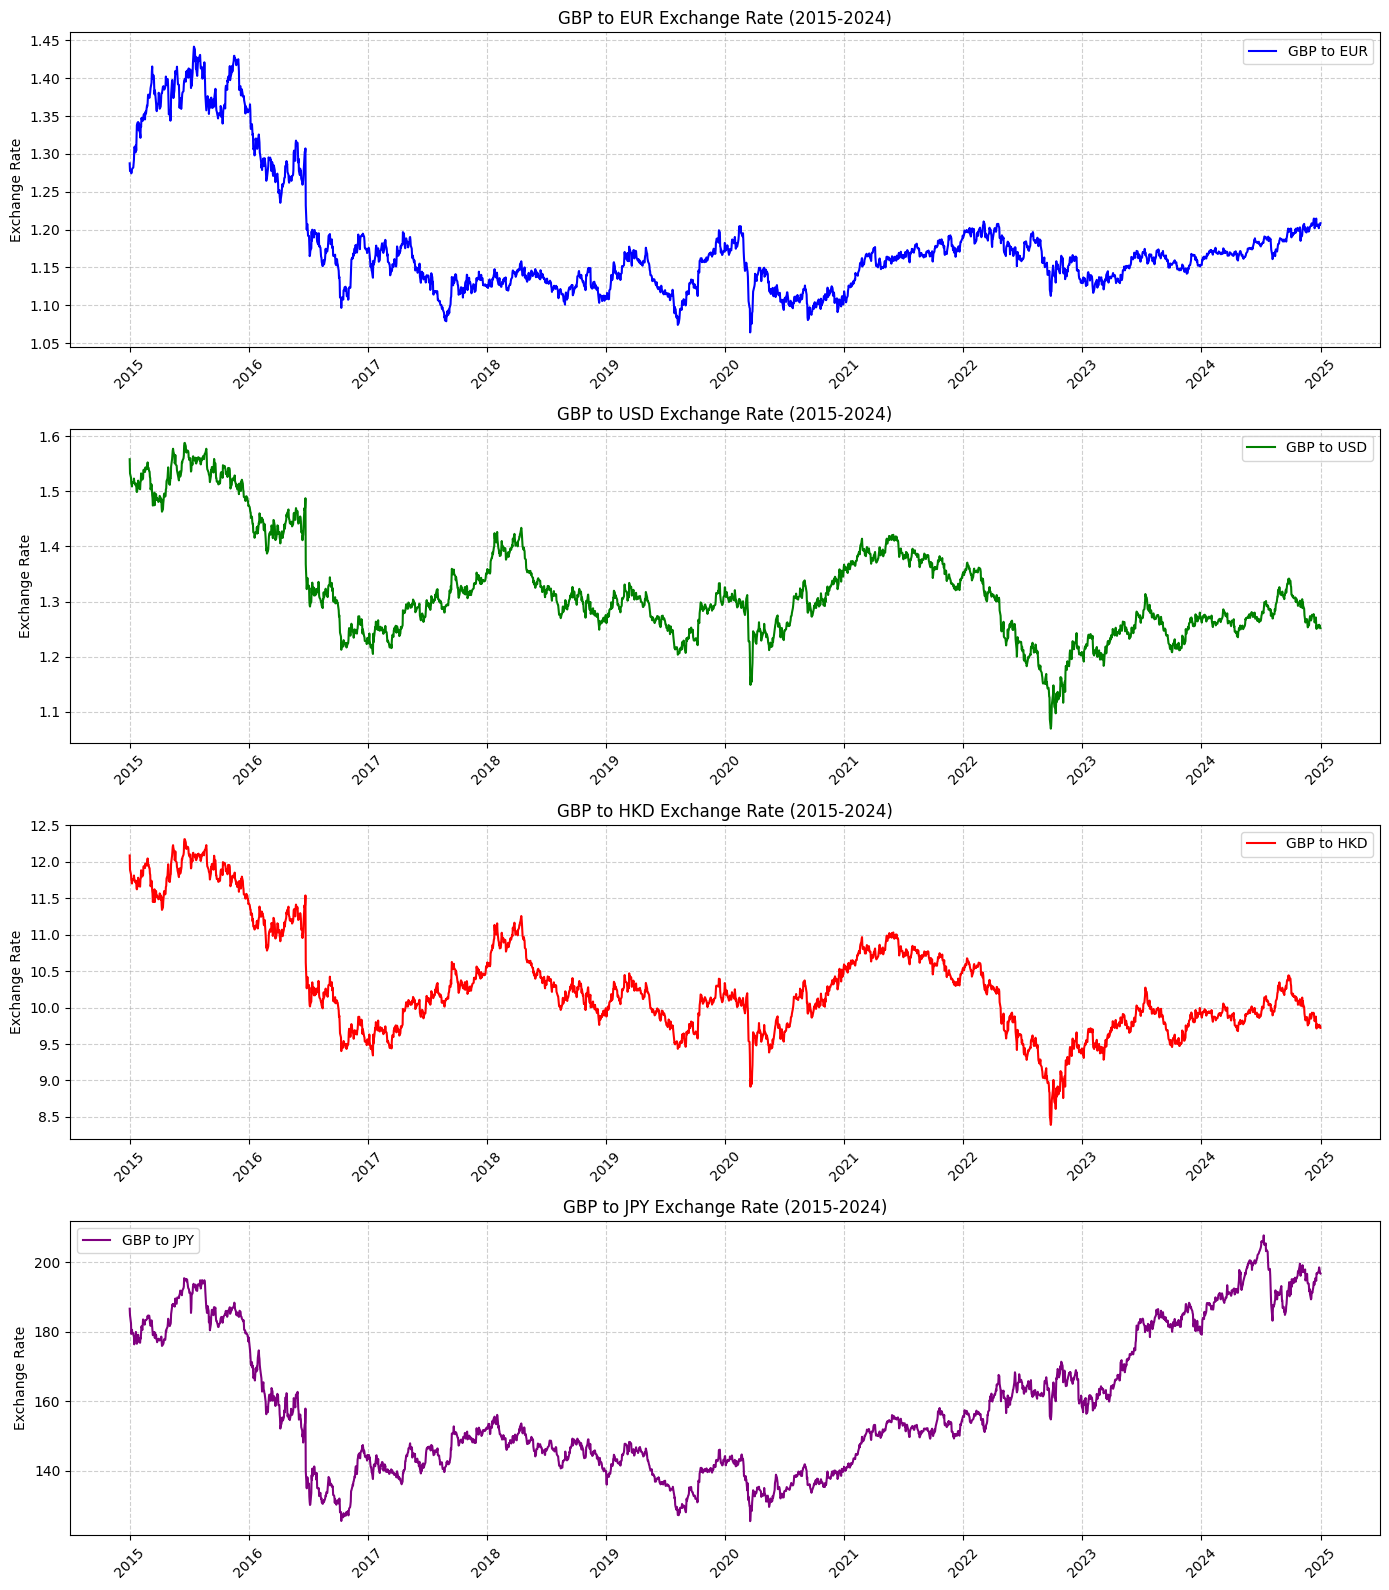

In [ ]:
# Create subplots for each currency pair
fig, axes = plt.subplots(4, 1, figsize=(14, 16))

# Plot GBP to EUR
axes[0].plot(plot_df['Date'], plot_df['GBP_EUR'], label='GBP to EUR', color='blue')
axes[0].set_title('GBP to EUR Exchange Rate (2015-2024)')
axes[0].set_ylabel('Exchange Rate')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# Plot GBP to USD
axes[1].plot(plot_df['Date'], plot_df['GBP_USD'], label='GBP to USD', color='green')
axes[1].set_title('GBP to USD Exchange Rate (2015-2024)')
axes[1].set_ylabel('Exchange Rate')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

# Plot GBP to HKD
axes[2].plot(plot_df['Date'], plot_df['GBP_HKD'], label='GBP to HKD', color='red')
axes[2].set_title('GBP to HKD Exchange Rate (2015-2024)')
axes[2].set_ylabel('Exchange Rate')
axes[2].legend()
axes[2].grid(True, linestyle='--', alpha=0.6)

# Plot GBP to JPY
axes[3].plot(plot_df['Date'], plot_df['GBP_JPY'], label='GBP to JPY', color='purple')
axes[3].set_title('GBP to JPY Exchange Rate (2015-2024)')
axes[3].set_ylabel('Exchange Rate')
axes[3].legend()
axes[3].grid(True, linestyle='--', alpha=0.6)

# Rotate x-axis labels for better readability
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()



---



# **LSTM model**

Training model for GBP_EUR...


<ipython-input-9-37ed39abdc13>:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Forward fill missing values
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - loss: 0.0153 - val_loss: 9.1697e-04
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - loss: 0.0018 - val_loss: 5.8448e-04
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - loss: 0.0017 - val_loss: 7.0313e-04
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 0.0014 - val_loss: 1.6339e-04
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - loss: 0.0013 - val_loss: 1.4478e-04
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - loss: 0.0012 - val_loss: 1.2553e-04
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - loss: 0.0011 - val_loss: 2.1129e-04
Epoch 9/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - loss: 8.3701e-04 - val_loss: 1.1494e-04
Epoch 10/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - loss: 9.9453e-04 - val_loss: 1.6211e-04
Epoch 11/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - loss: 8.0417e-04 -

Model for GBP_EUR saved successfully. MSE: 0.00005, R2: 0.99006


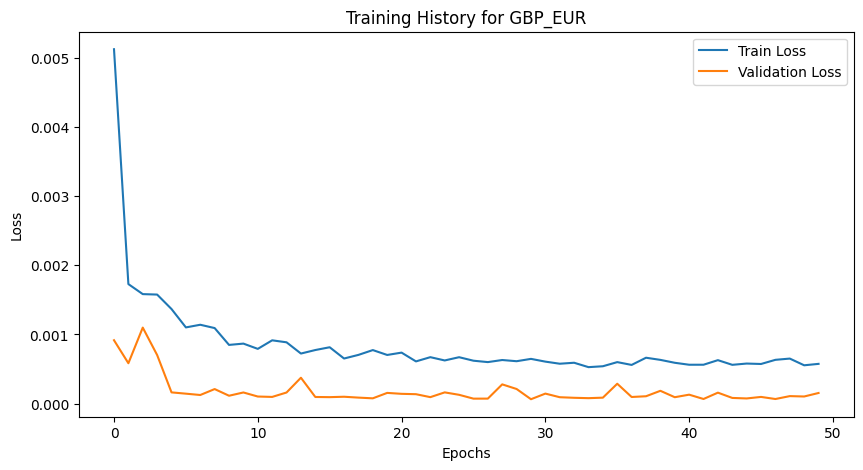

Training model for GBP_USD...
Epoch 1/50


<ipython-input-9-37ed39abdc13>:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Forward fill missing values
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - loss: 0.0370 - val_loss: 4.8337e-04
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 0.0022 - val_loss: 4.3818e-04
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - loss: 0.0023 - val_loss: 4.2611e-04
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - loss: 0.0018 - val_loss: 5.0672e-04
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - loss: 0.0021 - val_loss: 4.5332e-04
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - loss: 0.0016 - val_loss: 3.4135e-04
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - loss: 0.0014 - val_loss: 2.7617e-04
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - loss: 0.0015 - val_loss: 2.4652e-04
Epoch 9/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 0.0012 - val_loss: 2.7446e-04
Epoch 10/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 0.0011 - val_loss: 2.0998e-04
Epoch 11/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - loss: 9.1909e-04 - val_loss: 4.66

Model for GBP_USD saved successfully. MSE: 0.00007, R2: 0.99122


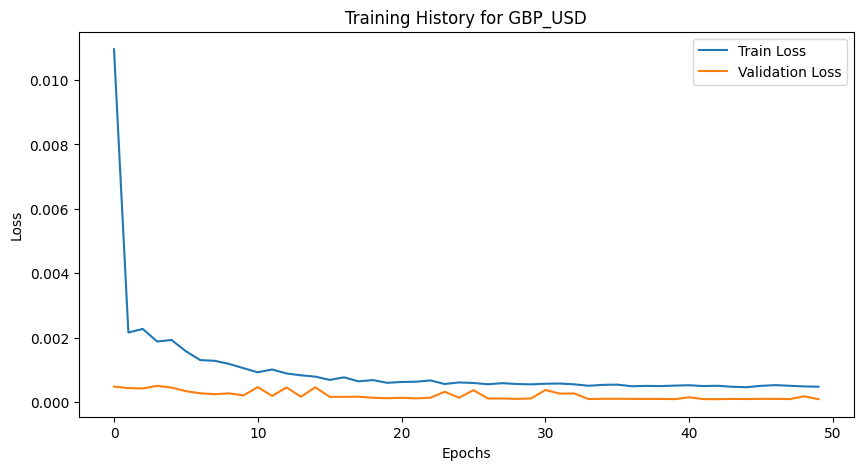

Training model for GBP_HKD...
Epoch 1/50


<ipython-input-9-37ed39abdc13>:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Forward fill missing values
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step - loss: 0.0258 - val_loss: 8.3635e-04
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 0.0024 - val_loss: 6.7305e-04
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 0.0023 - val_loss: 5.8667e-04
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 0.0020 - val_loss: 3.7485e-04
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 0.0015 - val_loss: 3.1101e-04
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 0.0015 - val_loss: 3.4009e-04
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 0.0013 - val_loss: 2.8242e-04
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0011 - val_loss: 2.8186e-04
Epoch 9/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 0.0011 - val_loss: 5.3511e-04
Epoch 10/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 9.5765e-04 - val_loss: 4.8545e-04
Epoch 11/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 0.0011 - val_loss: 3.3198

Model for GBP_HKD saved successfully. MSE: 0.00431, R2: 0.99068


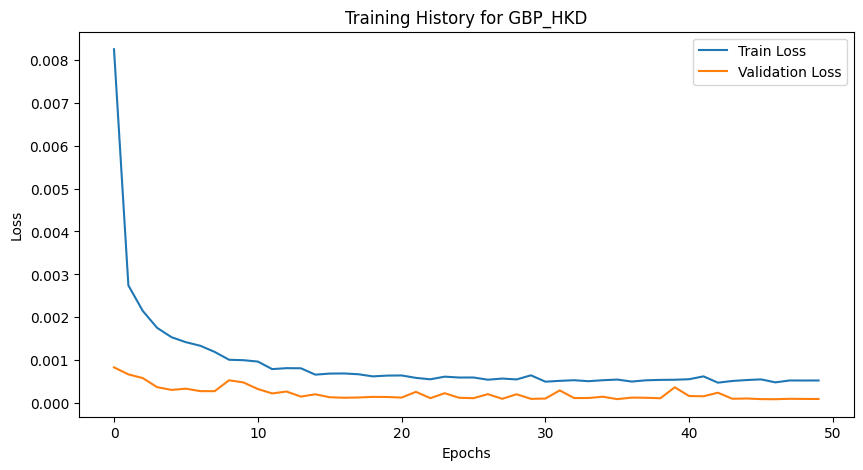

Training model for GBP_JPY...
Epoch 1/50


<ipython-input-9-37ed39abdc13>:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Forward fill missing values
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - loss: 0.0167 - val_loss: 0.0014
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - loss: 9.6701e-04 - val_loss: 0.0024
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 9.9202e-04 - val_loss: 8.6857e-04
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 9.1183e-04 - val_loss: 0.0012
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 7.0552e-04 - val_loss: 4.7069e-04
Epoch 9/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 7.1048e-04 - val_loss: 6.2434e-04
Epoch 10/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - loss: 6.5686e-04 - val_loss: 4.7603e-04
Epoch 11/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 6.3961e-04 - val_loss: 0.001

Model for GBP_JPY saved successfully. MSE: 1.59954, R2: 0.99598


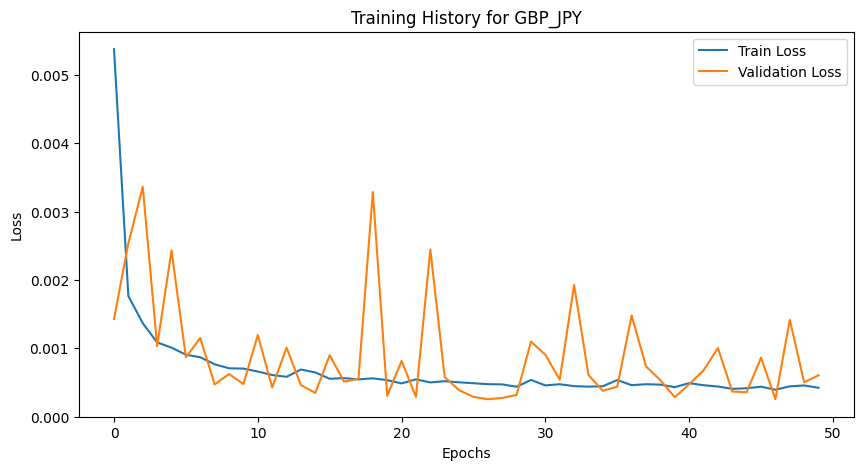

Training Results: {'GBP_EUR': {'MSE': 5.4161137600109325e-05, 'R2': 0.9900564508693254}, 'GBP_USD': {'MSE': 7.141146231864589e-05, 'R2': 0.991217486970329}, 'GBP_HKD': {'MSE': 0.004309572088645431, 'R2': 0.9906768451499894}, 'GBP_JPY': {'MSE': 1.5995383183061953, 'R2': 0.9959771502380014}}


In [ ]:
def prepare_data(currency, window_size=60):
    """Load and preprocess currency data."""
    data = plot_df.copy()
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data.fillna(method='ffill', inplace=True)  # Forward fill missing values

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data[[currency]])
    os.makedirs('models2', exist_ok=True)
    joblib.dump(scaler, f'models2/scaler_{currency}.pkl')

    X, y = [], []
    for i in range(len(scaled_data) - window_size):
        X.append(scaled_data[i:i + window_size])
        y.append(scaled_data[i + window_size])

    return np.array(X), np.array(y), scaler, data

def train_and_save_models(window_size=60, epochs=50, batch_size=16):
    """Train LSTM models for all currencies and save the best ones based on R2 score and MSE."""
    currencies = ['GBP_EUR', 'GBP_USD', 'GBP_HKD', 'GBP_JPY']
    results = {}

    for currency in currencies:
        print(f"Training model for {currency}...")
        X, y, scaler, data = prepare_data(currency, window_size)

        model = Sequential([
            LSTM(100, return_sequences=True, input_shape=(window_size, 1)),
            Dropout(0.2),
            LSTM(100, return_sequences=False),
            Dropout(0.2),
            Dense(50, activation='relu'),
            Dense(1)
        ])

        model.compile(optimizer='adam', loss='mse')
        history = model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.1)

        y_pred = model.predict(X)
        y_pred = scaler.inverse_transform(y_pred)
        y_actual = scaler.inverse_transform(y)

        mse = mean_squared_error(y_actual, y_pred)
        r2 = r2_score(y_actual, y_pred)
        results[currency] = {'MSE': mse, 'R2': r2}

        model.save(f'models2/model_{currency}.h5')
        print(f"Model for {currency} saved successfully. MSE: {mse:.5f}, R2: {r2:.5f}")

        # Plot training and validation loss
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Training History for {currency}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    return results


if __name__ == "__main__":
    results = train_and_save_models()
    print("Training Results:", results)


In [ ]:
def load_model_and_predict(currency, start_date=None, end_date=None, window_size=60):
    """Load LSTM model and predict future currency rates with improved fluctuations."""
    custom_objects = {"mse": MeanSquaredError()}
    model = load_model(f'models2/model_{currency}.h5', custom_objects=custom_objects)
    # Explicitly compile with correct loss function
    model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
    scaler = joblib.load(f'models2/scaler_{currency}.pkl')

    data = plot_df.copy()
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    if start_date is None or end_date is None:
        start_date = datetime.date.today()
        end_date = start_date + datetime.timedelta(days=7)
    else:
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)

    last_window = data[currency].iloc[-window_size:].values.reshape(-1, 1)
    last_window = scaler.transform(last_window)

    predictions = []
    current_window = last_window
    future_dates = pd.date_range(start=start_date, end=end_date)

    # Train ARIMA model for better fluctuation modeling
    arima_model = ARIMA(data[currency].dropna(), order=(2, 1, 2)).fit()

    for i, date in enumerate(future_dates):
        pred = model.predict(current_window.reshape(1, window_size, 1))
        pred_value = scaler.inverse_transform(pred)[0, 0]

        # Adjust with ARIMA-based fluctuations
        arima_forecast = arima_model.forecast(steps=1).iloc[0]
        pred_value = (pred_value + arima_forecast) / 2  # Averaging for stability

        predictions.append((date, round(pred_value, 3)))
        current_window = np.append(current_window[1:], pred, axis=0)

    # Plot actual vs predicted
    plt.figure(figsize=(12, 5))
    plt.plot(data.index[-100:], data[currency].values[-100:], label='Historical Data', color='blue')
    plt.plot([p[0] for p in predictions], [p[1] for p in predictions], label='Predicted Data', color='red', linestyle='dashed')
    plt.title(f'{currency} - Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Currency Value')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

    return predictions

In [ ]:
def user_input():
    currency = input("Enter the currency (GBP_EUR, GBP_USD, GBP_HKD, GBP_JPY): ")
    start_date = input("Enter the start date (YYYY-MM-DD) or press Enter for default: ")
    end_date = input("Enter the end date (YYYY-MM-DD) or press Enter for default: ")

    start_date = start_date if start_date else None
    end_date = end_date if end_date else None

    predicted_rates = load_model_and_predict(currency, start_date, end_date)
    print(f"\nPredicted rates for {currency} from {start_date} to {end_date}:\n")
    for date, rate in predicted_rates:
        print(f"{date}: {rate}")

Enter the currency (GBP_EUR, GBP_USD, GBP_HKD, GBP_JPY): GBP_JPY
Enter the start date (YYYY-MM-DD) or press Enter for default: 2024-12-10
Enter the end date (YYYY-MM-DD) or press Enter for default: 2024-12-30


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


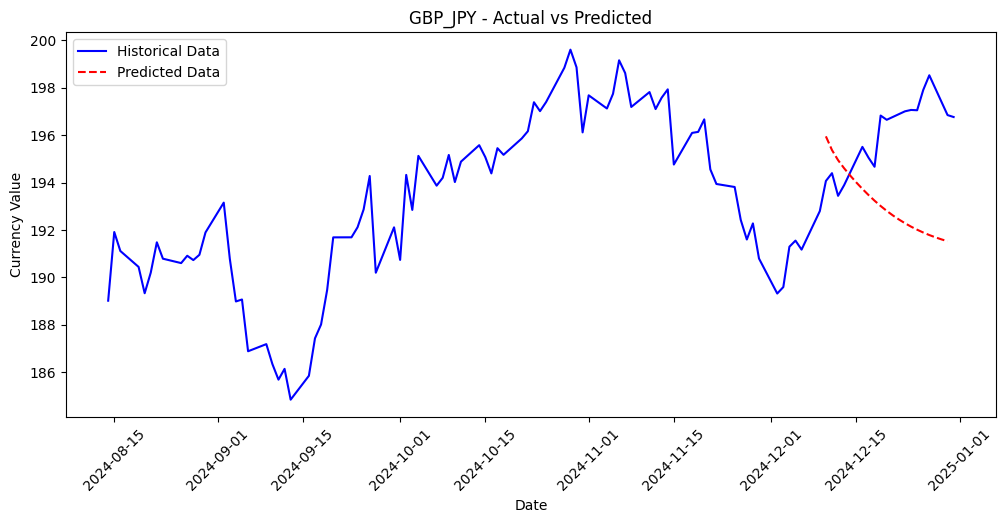


Predicted rates for GBP_JPY from 2024-12-10 to 2024-12-30:

2024-12-10 00:00:00: 195.948
2024-12-11 00:00:00: 195.369
2024-12-12 00:00:00: 194.944
2024-12-13 00:00:00: 194.6
2024-12-14 00:00:00: 194.292
2024-12-15 00:00:00: 194.003
2024-12-16 00:00:00: 193.731
2024-12-17 00:00:00: 193.474
2024-12-18 00:00:00: 193.233
2024-12-19 00:00:00: 193.009
2024-12-20 00:00:00: 192.803
2024-12-21 00:00:00: 192.613
2024-12-22 00:00:00: 192.44
2024-12-23 00:00:00: 192.282
2024-12-24 00:00:00: 192.138
2024-12-25 00:00:00: 192.008
2024-12-26 00:00:00: 191.89
2024-12-27 00:00:00: 191.783
2024-12-28 00:00:00: 191.687
2024-12-29 00:00:00: 191.6
2024-12-30 00:00:00: 191.522


In [ ]:
user_input()

# **Comparison of ARIMA, Random forest and LSTM**

In [ ]:
def evaluate_models_on_currency(currency, window_size=60):
    """Train ARIMA and Random Forest models, and compare them with LSTM."""
    print(f"\nEvaluating {currency}...")

    # Prepare data
    data = plot_df.copy()
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data.fillna(method='ffill', inplace=True)

    values = data[[currency]].dropna()

    # --- LSTM Model Evaluation ---
    scaler = joblib.load(f'models2/scaler_{currency}.pkl')
    X_lstm, y_lstm = [], []

    scaled_values = scaler.transform(values)

    for i in range(window_size, len(scaled_values)):
        X_lstm.append(scaled_values[i-window_size:i])
        y_lstm.append(scaled_values[i])

    X_lstm = np.array(X_lstm)
    y_lstm = np.array(y_lstm)

    model_lstm = load_model(f'models2/model_{currency}.h5', custom_objects={"mse": MeanSquaredError()})
    model_lstm.compile(optimizer='adam', loss='mse')
    lstm_pred_scaled = model_lstm.predict(X_lstm)
    lstm_pred = scaler.inverse_transform(lstm_pred_scaled)
    y_lstm_actual = scaler.inverse_transform(y_lstm)

    lstm_mse = mean_squared_error(y_lstm_actual, lstm_pred)
    lstm_r2 = r2_score(y_lstm_actual, lstm_pred)

    # --- ARIMA Model Evaluation ---
    # Use only training set (last part for testing)
    train_arima = values.iloc[:-30]
    test_arima = values.iloc[-30:]

    arima_model = ARIMA(train_arima, order=(2, 1, 2)).fit()
    arima_forecast = arima_model.forecast(steps=len(test_arima))
    arima_mse = mean_squared_error(test_arima.values, arima_forecast.values)
    arima_r2 = r2_score(test_arima.values, arima_forecast.values)

    # --- Random Forest Model Evaluation ---
    df_rf = values.copy()
    for i in range(1, window_size + 1):
        df_rf[f'lag_{i}'] = df_rf[currency].shift(i)
    df_rf.dropna(inplace=True)

    X_rf = df_rf.drop(columns=[currency]).values
    y_rf = df_rf[currency].values

    X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, shuffle=False)

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train_rf, y_train_rf)
    rf_pred = rf_model.predict(X_test_rf)

    rf_mse = mean_squared_error(y_test_rf, rf_pred)
    rf_r2 = r2_score(y_test_rf, rf_pred)

    # Return results
    return {
        'Currency': currency,
        'LSTM_MSE': lstm_mse,
        'LSTM_R2': lstm_r2,
        'ARIMA_MSE': arima_mse,
        'ARIMA_R2': arima_r2,
        'RF_MSE': rf_mse,
        'RF_R2': rf_r2
    }


def compare_all_models():
    currencies = ['GBP_EUR', 'GBP_USD', 'GBP_HKD', 'GBP_JPY']
    results = []

    for currency in currencies:
        result = evaluate_models_on_currency(currency)
        results.append(result)

    df_results = pd.DataFrame(results)
    print("\nModel Comparison Results:\n")
    print(df_results)
    return df_results


# Run the comparison
comparison_df = compare_all_models()



Evaluating GBP_EUR...


<ipython-input-41-a809cf1feb81>:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u


Evaluating GBP_USD...
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p


Evaluating GBP_HKD...
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p


Evaluating GBP_JPY...
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/di


Model Comparison Results:

  Currency  LSTM_MSE   LSTM_R2  ARIMA_MSE  ARIMA_R2     RF_MSE     RF_R2
0  GBP_EUR  0.000054  0.990056   0.000096 -4.171703   0.000013  0.969898
1  GBP_USD  0.000071  0.991217   0.000097 -0.371852   0.000039  0.953917
2  GBP_HKD  0.004310  0.990677   0.007131 -0.492986   0.002385  0.945849
3  GBP_JPY  1.599538  0.995977  10.286051 -0.625148  10.342992  0.925939
